# WORKFLOW 2

In [1]:
# IMPORTS
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
# GLOBAL VARIABLES
execution_count = 1  # Adjust as needed
window_size = 100
window_size_std = 400

dates = ["2025-02-03", "2025-02-04", "2025-02-05", "2025-02-06", "2025-02-07", "2025-02-08", "2025-02-09"]

folder_to_save = "./experiment_plots"

optimized_color = sns.color_palette("Blues", n_colors=1)[0]  # Main blue shade
baseline_color = sns.color_palette("Oranges", n_colors=1)[0]  # Main orange shade


theme_style = "darkgrid"
color_palette_style = "deep"
color_palette_style_2 = "viridis"
palette = sns.color_palette(color_palette_style)
palette_2 = sns.color_palette(color_palette_style_2)
sns.set_theme(style=theme_style)

# Define y axis label
y_axis_label = "Improvement Over Baseline (%)"

y_axis_label_bm_failed_attempts = "Failed Benchmark Attempts (%)"

file_ending = ".pdf"

In [3]:
# PREPARE DATA GROUPED

# prepare optimized data
df_list = []
for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-optimizedFunction-logs.csv'
    
    if os.path.exists(file_path):  # Check if file exists to avoid errors
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
        df['day'] = df['timestamp'].dt.date  # Extract date to a new column
        df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60  # Normalize time
        df['smoothed_execution_time'] = df['execution_time'].rolling(window=window_size).mean()

        df_list.append(df)
# Concatenate all dataframes
df_all_days_optimized = pd.concat(df_list, ignore_index=True)


# prepare baseline data
df_list = []
for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-baselineFunction-logs.csv'
    
    if os.path.exists(file_path):  # Check if file exists to avoid errors
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
        df['day'] = df['timestamp'].dt.date  # Extract date to a new column
        df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60  # Normalize time
        df['smoothed_execution_time'] = df['execution_time'].rolling(window=window_size).mean()

        df_list.append(df)
# Concatenate all dataframes
df_all_days_baseline = pd.concat(df_list, ignore_index=True)



# GROUP ALL DAYS TOGETHER
df_optimized_all_days = df_all_days_optimized
# Sort the dataframe by duration_minutes to ensure proper rolling calculations
df_optimized_all_days = df_optimized_all_days.sort_values(by='duration_minutes')

df_baseline_all_days = df_all_days_baseline
# Sort the dataframe by duration_minutes to ensure proper rolling calculations
df_baseline_all_days = df_baseline_all_days.sort_values(by='duration_minutes')


# Compute rolling median & std for optimized function
df_optimized_all_days['smoothed_median'] = df_optimized_all_days['execution_time'].rolling(window=window_size, center=True).median()
df_optimized_all_days['smoothed_std'] = df_optimized_all_days['execution_time'].rolling(window=window_size_std, center=True).std()

# Compute rolling median & std for baseline function
df_baseline_all_days['smoothed_median'] = df_baseline_all_days['execution_time'].rolling(window=window_size, center=True).median()
df_baseline_all_days['smoothed_std'] = df_baseline_all_days['execution_time'].rolling(window=window_size_std, center=True).std()

# Drop NaNs
df_optimized_all_days = df_optimized_all_days.dropna(subset=['smoothed_median', 'smoothed_std'])
df_baseline_all_days = df_baseline_all_days.dropna(subset=['smoothed_median', 'smoothed_std'])

# Get max duration
max_duration = max(df_optimized_all_days['duration_minutes'].max(), df_baseline_all_days['duration_minutes'].max())

In [4]:
# PREPARE DATA FOR EACH METRIC (IMPROVEMENTS)

# Dictionary to store improvement values for each metric
metric_improvements = {}

# READ FILES
for date in dates:
    data_dir = f"./logs_analysis/{date}/execution_{execution_count}/"
    file_path = os.path.join(data_dir, f"table.json")
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
            for entry in data:
                metric = entry["Metric"]
                improvement = entry["% Improvement"]  # Keep original value
                
                if metric not in metric_improvements:
                    metric_improvements[metric] = []

                # Store the (date, improvement) tuple
                metric_improvements[metric].append((date, improvement))

    except FileNotFoundError:
        print(f"Warning: File for {date} not found, skipping.")


# PREPARE METRICS DATA FOR PLOTS 

# Convert metric_improvements dictionary into a DataFrame
df_list = []
for metric, values in metric_improvements.items():
    for date, improvement in values:
        df_list.append({"Date": date, "Metric": metric, "% Improvement": improvement})

df = pd.DataFrame(df_list)

# Convert Date column to datetime format for proper plotting
df["Date"] = pd.to_datetime(df["Date"])

# Define relevant metrics for plotting
relevant_metrics = ["Function Execution Time", "Download Duration", "Linear Regression Execution Time"]

# Filter data for the first plot
df_filtered = df[df["Metric"].isin(relevant_metrics)]
df_filtered2 = df[df["Metric"].isin(["Function Execution Time", "Linear Regression Execution Time"])]
df_function_execution_time = df[df["Metric"].isin(["Function Execution Time"])]

# Convert 'dates' list to datetime format before creating the mapping
dates_datetime = pd.to_datetime(dates)  # Ensures correct format
# Create mapping using datetime keys
date_mapping = {date: f"Day {i+1}" for i, date in enumerate(sorted(dates_datetime))}
# Apply the mapping to the 'day' column
df_filtered['day_label'] = df_filtered['Date'].map(date_mapping)
df_filtered2['day_label'] = df_filtered2['Date'].map(date_mapping)
df_function_execution_time['day_label'] = df_function_execution_time['Date'].map(date_mapping)

df_filtered_task = df_filtered.copy(deep=True)
df_filtered_task["Metric"] = df_filtered_task["Metric"].replace(
    {"Linear Regression Execution Time": "Task Execution Time"}
)
df_filtered_task_2 = df_filtered2.copy(deep=True)
df_filtered_task_2["Metric"] = df_filtered_task_2["Metric"].replace(
    {"Linear Regression Execution Time": "Task Execution Time"}
)


# Define color palette for consistency
num_days = df["Date"].nunique()

/var/folders/3w/450cp8190_d0ny9_wdcmgsgc0000gn/T/ipykernel_57777/1189609160.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered2['day_label'] = df_filtered2['Date'].map(date_mapping)
/var/folders/3w/450cp8190_d0ny9_wdcmgsgc0000gn/T/ipykernel_57777/1189609160.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_function_execution_time['day_label'] = df_function_execution_time['Date'].map(date_mapping)


In [5]:
# ANALYSING BENCHMARK PASSED AND BM >

# Define a list to store the benchmark statistics for each file
benchmark_stats_list = []

# Function to extract benchmark numbers (as already defined)
def extract_bm_passed(value):
    if isinstance(value, str) and value.startswith("BM PASSED:"):
        return float(value.split(":")[1].strip())
    return None

def extract_bm_failed(value):
    if isinstance(value, str) and value.startswith("BM:"):
        return float(value.split(":")[1].split(">")[0].strip())
    return None

def extract_bm_threshold(value):
    if isinstance(value, str) and value.startswith("BM:") and ">" in value:
        return float(value.split(">")[1].strip())
    return None


failed_benchmark_count_array = []
failed_benchmark_count_percentage_array = []
bm_threshold_array = []
# Loop through all dates and compute benchmark stats
for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-optimizedFunction-logs.csv'
    
    if os.path.exists(file_path):  # Check if file exists to avoid errors
        
        df = pd.read_csv(file_path)

        # Apply benchmark extraction functions
        df["bm_passed"] = df["benchmark_duration"].apply(extract_bm_passed)
        df["bm_failed"] = df["benchmark_duration"].apply(extract_bm_failed)
        bm_threshold = df["benchmark_duration"].apply(extract_bm_threshold).dropna().iloc[0]

        # Compute statistics
        bm_passed_avg = np.nanmean(df["bm_passed"])
        bm_passed_median = np.nanmedian(df["bm_passed"])
        bm_failed_avg = np.nanmean(df["bm_failed"])
        bm_failed_median = np.nanmedian(df["bm_failed"])

        # Append stats as a tuple to the list
        benchmark_stats_list.append((date, bm_passed_avg, bm_passed_median, bm_failed_avg, bm_failed_median, bm_threshold))

        # Count failed benchmarks
        failed_benchmark_count = df["bm_failed"].notna().sum()
        failed_benchmark_count_array.append(failed_benchmark_count)
        
        total_count = len(df)
        failed_benchmark_percentage = (failed_benchmark_count / total_count) * 100 if total_count > 0 else 0
        failed_benchmark_count_percentage_array.append(failed_benchmark_percentage)

        bm_threshold_array.append(bm_threshold)


# Convert benchmark stats list to DataFrame
stats_df = pd.DataFrame(benchmark_stats_list, columns=["Date", "bm_passed_avg", "bm_passed_median", "bm_failed_avg", "bm_failed_median", "bm_threshold"])
# Ensure that the day_label is added to the stats_df DataFrame
stats_df['day_label'] = stats_df['Date'].map(date_mapping)

# Melt the DataFrame
df_melted_avg = stats_df.melt(id_vars=["Date", "day_label"], 
                          value_vars=["bm_passed_avg", "bm_failed_avg", "bm_threshold"], 
                          var_name="Metric", 
                          value_name="Value")

df_melted_median = stats_df.melt(id_vars=["Date", "day_label"], 
                          value_vars=["bm_passed_median", "bm_failed_median", "bm_threshold"], 
                          var_name="Metric", 
                          value_name="Value")

df_bm_and_failedavg = stats_df.melt(id_vars=["Date", "day_label"], 
                             value_vars=["bm_failed_avg", "bm_threshold"],
                             var_name="Metric", 
                             value_name="Value")

In [6]:
# # Calculate the percentage difference to the threshold for each day
# stats_df['bm_passed_avg_percentage_diff'] = (stats_df['bm_passed_avg'] - stats_df['bm_threshold']) / stats_df['bm_threshold'] * 100
# stats_df['bm_failed_avg_percentage_diff'] = (stats_df['bm_failed_avg'] - stats_df['bm_threshold']) / stats_df['bm_threshold'] * 100


# # Print the percentage differences for each day
# for index, row in stats_df.iterrows():
#     print(f"Date: {row['Date']}")
#     print(f"bm_passed_avg Percentage Difference: {row['bm_passed_avg_percentage_diff']:.2f}%")
#     print(f"bm_failed_avg Percentage Difference: {row['bm_failed_avg_percentage_diff']:.2f}%")
#     print("-" * 40)

# # Calculate total difference over the week for both passed and failed averages
# total_passed_avg_diff = stats_df['bm_passed_avg_percentage_diff'].sum() / 7
# total_failed_avg_diff = stats_df['bm_failed_avg_percentage_diff'].sum() / 7

# print("\nTotal Difference Over the Week:")
# print(f"Total bm_passed_avg Percentage Difference: {total_passed_avg_diff:.2f}%")
# print(f"Total bm_failed_avg Percentage Difference: {total_failed_avg_diff:.2f}%")

##### GRAPHS FOR EXECUTIONS: SINGULAR AND GROUPED

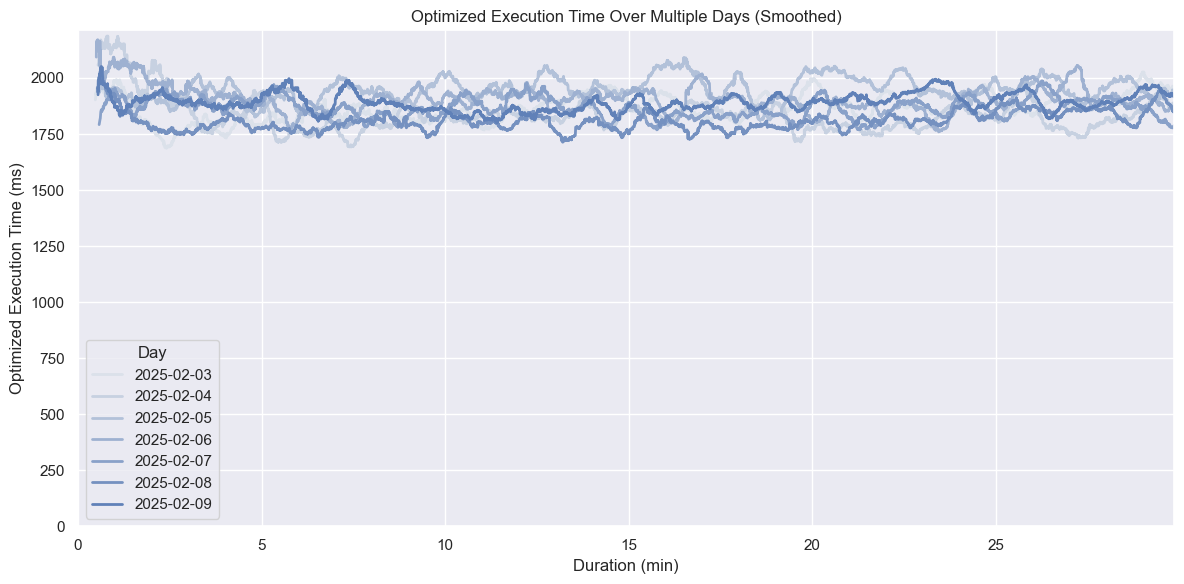

In [7]:
# OPTIMIZED EXECUTIONS
sns.set_theme(style=theme_style)
num_days = df_all_days_optimized["day"].nunique()
palette = sns.color_palette("light:b", n_colors=num_days+2)[1:-1]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot execution time for different days
sns.lineplot(
    data=df_all_days_optimized, 
    x='duration_minutes', 
    y='smoothed_execution_time', 
    hue='day', 
    lw=2, 
    palette=palette
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Optimized Execution Time (ms)')
plt.title('Optimized Execution Time Over Multiple Days (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0, right=max_duration)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "execution-times-optimized" + file_ending)
plt.savefig(plot_filename)
# SHOW PLOT
plt.show()

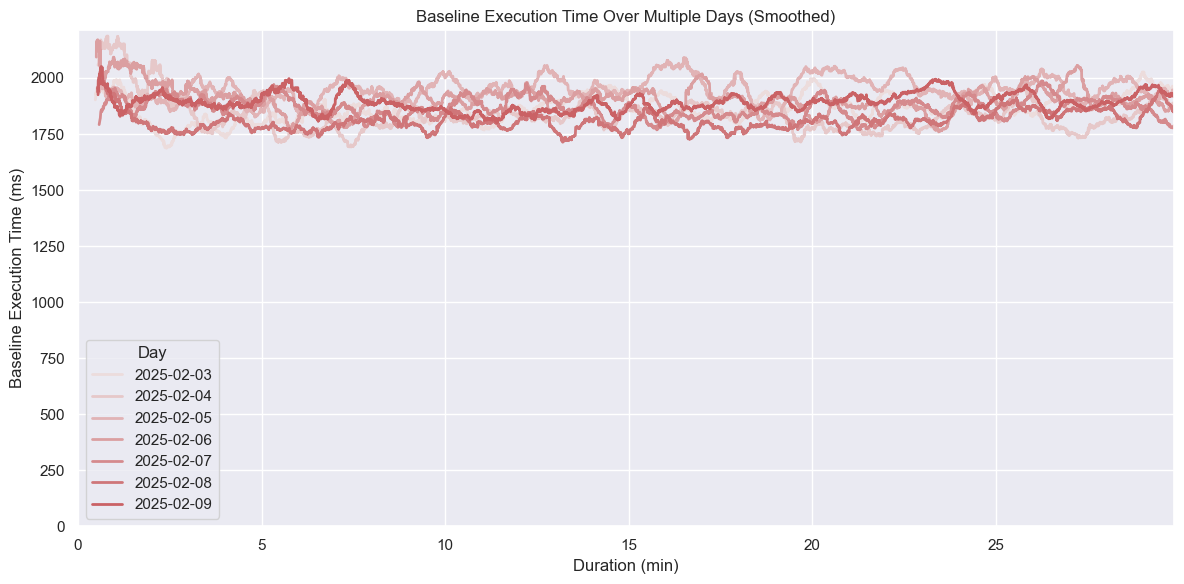

In [8]:
# BASELINE EXECUTIONS
sns.set_theme(style=theme_style)
# palette = sns.color_palette("YlOrBr", n_colors=df_all_days_optimized["day"].nunique())
num_days = df_all_days_optimized["day"].nunique()
palette = sns.color_palette("light:r", n_colors=num_days+2)[1:-1]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot execution time for different days
sns.lineplot(
    data=df_all_days_optimized, 
    x='duration_minutes', 
    y='smoothed_execution_time', 
    hue='day', 
    lw=2, 
    palette=palette
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Baseline Execution Time (ms)')
plt.title('Baseline Execution Time Over Multiple Days (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0, right=max_duration)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "execution-times-baseline" + file_ending)
plt.savefig(plot_filename)
# SHOW PLOT
plt.show()

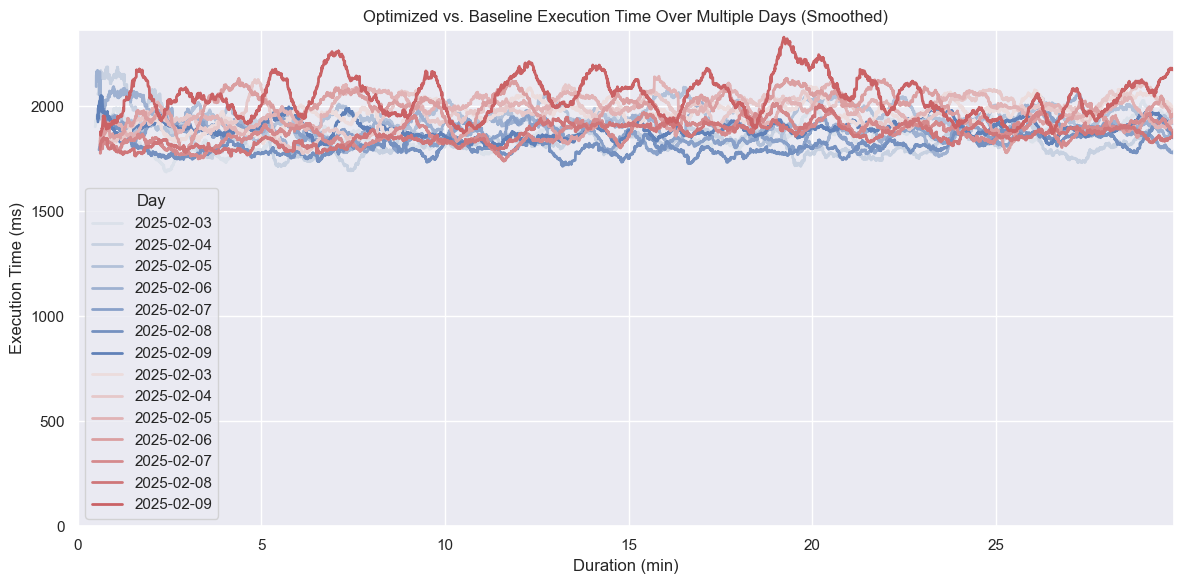

In [9]:
# BASELINE AND OPTIMIZED EXECUTIONS IN ONE GRAPH
sns.set_theme(style=theme_style)
num_days = df_all_days_optimized["day"].nunique()

# Define color palettes
optimized_palette = sns.color_palette("light:b", n_colors=num_days+2)[1:-1]
baseline_palette = sns.color_palette("light:r", n_colors=num_days+2)[1:-1]

plt.figure(figsize=(12, 6))

# Plot optimized execution times
optimized_lines = sns.lineplot(
    data=df_all_days_optimized,
    x='duration_minutes',
    y='smoothed_execution_time',
    hue='day',
    lw=2,
    palette=optimized_palette
)

# Plot baseline execution times
baseline_lines = sns.lineplot(
    data=df_all_days_baseline,
    x='duration_minutes',
    y='smoothed_execution_time',
    hue='day',
    lw=2,
    palette=baseline_palette
)

# Labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Optimized vs. Baseline Execution Time Over Multiple Days (Smoothed)')

plt.xlim(left=0, right=max_duration)
plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Day")

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "execution-times-optimized-and-baseline" + file_ending)
plt.savefig(plot_filename)

# SHOW PLOT
plt.show()

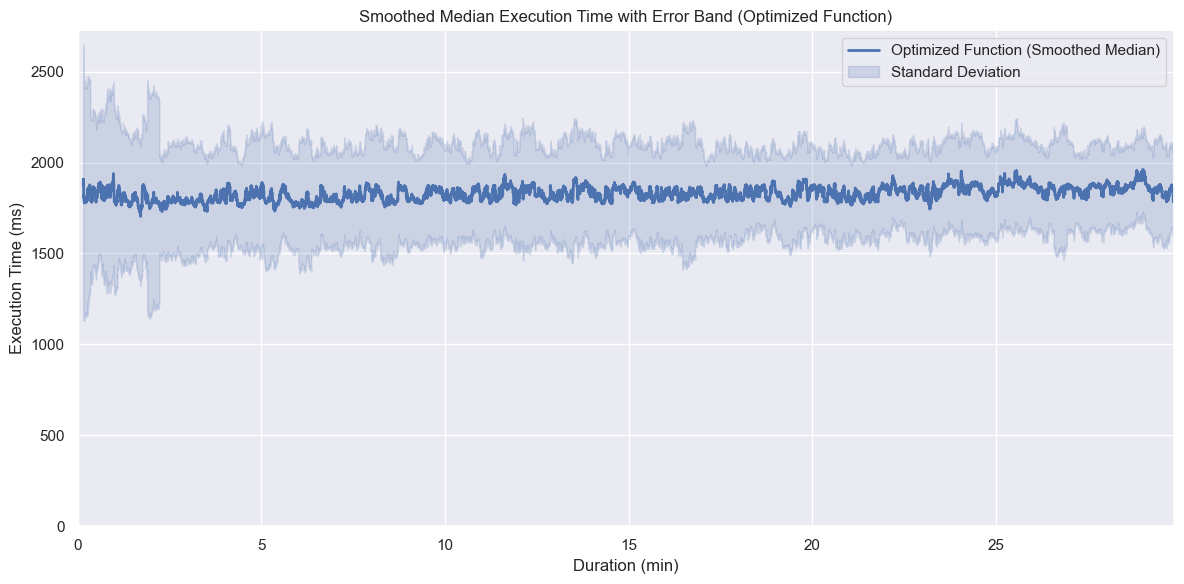

In [10]:
# GROUPED OPTIMIZED RESULTS WITH ERROR BAND

# Plot the data
sns.set_theme(style=theme_style)
palette = sns.color_palette(color_palette_style)

plt.figure(figsize=(12, 6))

# Plot smoothed median execution time
sns.lineplot(
    data=df_optimized_all_days,
    x='duration_minutes',
    y='smoothed_median',
    color=palette[0],
    label='Optimized Function (Smoothed Median)',
    lw=2
)

# Add error band using standard deviation
plt.fill_between(
    df_optimized_all_days['duration_minutes'],
    df_optimized_all_days['smoothed_median'] - df_optimized_all_days['smoothed_std'],
    df_optimized_all_days['smoothed_median'] + df_optimized_all_days['smoothed_std'],
    color=palette[0],
    alpha=0.2,
    label='Standard Deviation'
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Smoothed Median Execution Time with Error Band (Optimized Function)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0, right=max_duration)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "grouped-optimized-error-bands" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

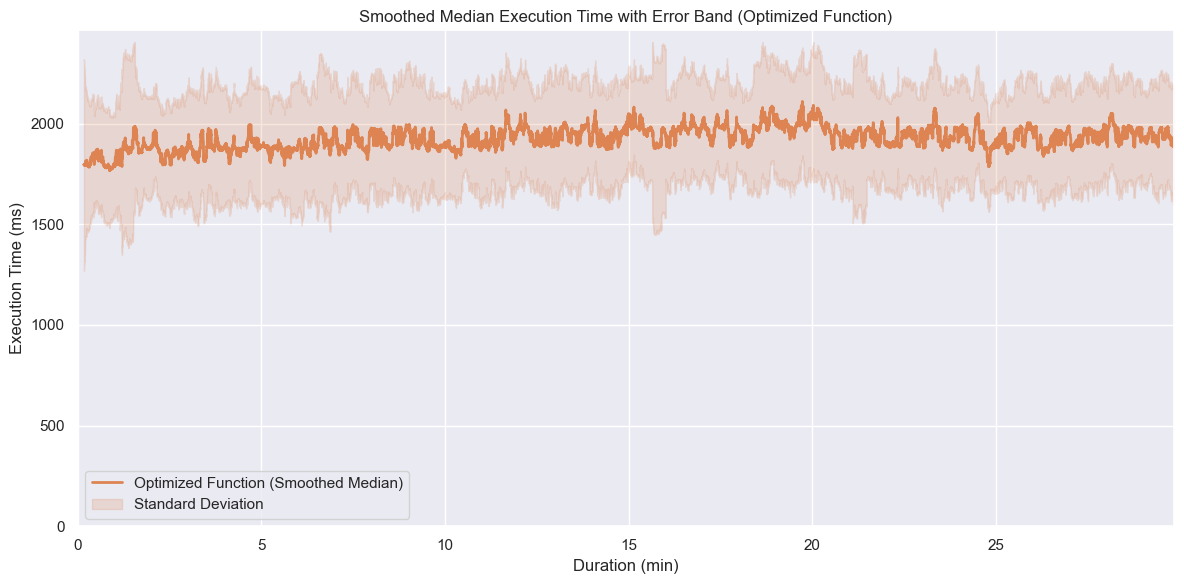

In [11]:
# GROUPED BASELINE RESULTS WITH ERROR BAND

# Plot the data
sns.set_theme(style=theme_style)
palette = sns.color_palette(color_palette_style)

plt.figure(figsize=(12, 6))

# Plot smoothed median execution time
sns.lineplot(
    data=df_baseline_all_days,
    x='duration_minutes',
    y='smoothed_median',
    color=palette[1],
    label='Optimized Function (Smoothed Median)',
    lw=2
)

# Add error band using standard deviation
plt.fill_between(
    df_baseline_all_days['duration_minutes'],
    df_baseline_all_days['smoothed_median'] - df_baseline_all_days['smoothed_std'],
    df_baseline_all_days['smoothed_median'] + df_baseline_all_days['smoothed_std'],
    color=palette[1],
    alpha=0.2,
    label='Standard Deviation'
)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Smoothed Median Execution Time with Error Band (Optimized Function)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0, right=max_duration)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "grouped-baseline-error-bands" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

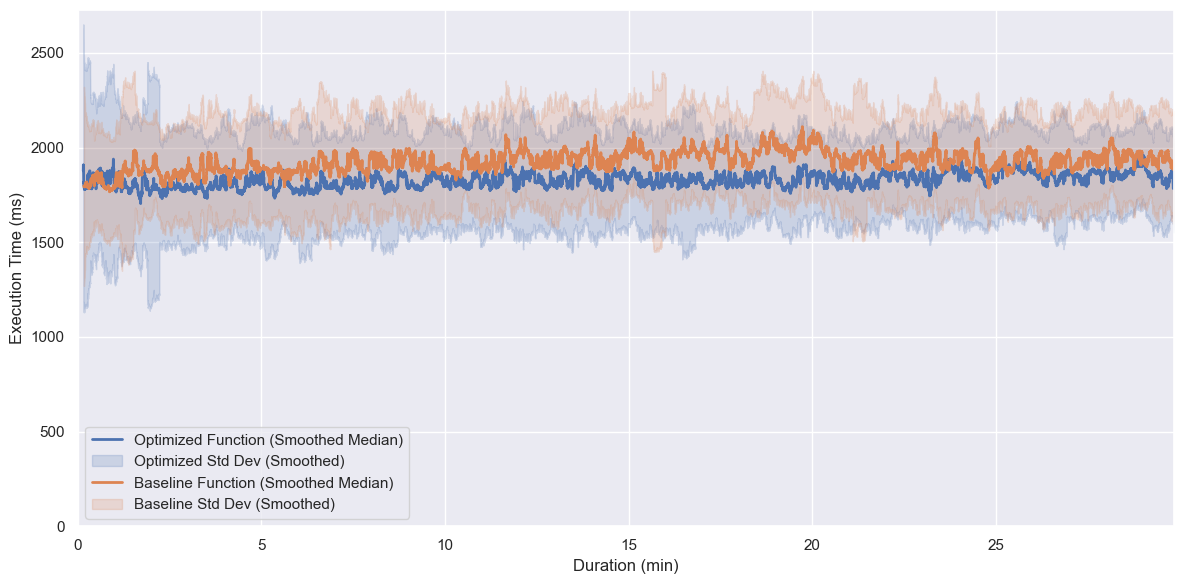

In [12]:
# GROUPED RESULTS WITH ERROR BANDS

# Set up plot
sns.set_theme(style=theme_style)
palette = sns.color_palette(color_palette_style)

plt.figure(figsize=(12, 6))

# Optimized function
sns.lineplot(
    data=df_optimized_all_days, x='duration_minutes', y='smoothed_median',
    color=palette[0], label='Optimized Function (Smoothed Median)', lw=2
)
plt.fill_between(
    df_optimized_all_days['duration_minutes'],
    df_optimized_all_days['smoothed_median'] - df_optimized_all_days['smoothed_std'],
    df_optimized_all_days['smoothed_median'] + df_optimized_all_days['smoothed_std'],
    color=palette[0], alpha=0.2, label='Optimized Std Dev (Smoothed)'
)

# Baseline function
sns.lineplot(
    data=df_baseline_all_days, x='duration_minutes', y='smoothed_median',
    color=palette[1], label='Baseline Function (Smoothed Median)', lw=2
)
plt.fill_between(
    df_baseline_all_days['duration_minutes'],
    df_baseline_all_days['smoothed_median'] - df_baseline_all_days['smoothed_std'],
    df_baseline_all_days['smoothed_median'] + df_baseline_all_days['smoothed_std'],
    color=palette[1], alpha=0.2, label='Baseline Std Dev (Smoothed)'
)

# Labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')

# Axis limits
plt.xlim(left=0, right=max_duration)
plt.ylim(bottom=0)

# Legend
plt.legend()

# Layout adjustment
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "grouped-optimized-and-baseline-error-bands" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

##### TABLES

In [13]:
# IMPROVEMENT OVER ALL DAYS

# Convert DATA into Pandas DataFrames
tables = {}
for metric, values in metric_improvements.items():
    df = pd.DataFrame(values, columns=["Date", "% Improvement"])
    df.sort_values("Date", inplace=True)
    
    # Save table
    safe_metric_name = metric.lower().replace(" ", "_")
    file_name = f"table-{safe_metric_name}.json"
    output_path = os.path.join(folder_to_save, file_name)
    df.to_json(output_path, orient="records", indent=4)

    # Apply formatting (1 decimal place for % Improvement)
    styled_df = df.style.format({"% Improvement": "{:.2f}%"}) \
                        .set_table_styles([{
                            'selector': 'thead th', 
                            'props': [
                                ('font-size', '14px'), 
                                ('text-align', 'center'),
                                ('font-weight', 'bold')
                            ],
                        }]) \
                        .set_properties(**{
                            'text-align': 'center',
                            'font-size': '12px',
                            'padding': '7px',
                        }) \
                        .hide(axis="index")
    
    tables[metric] = styled_df  # Store formatted DataFrame for each metric

# DISPLAY TABLES
for metric, styled_df in tables.items():
    print(f"\n{metric}")
    display(styled_df)  # Shows the styled table nicely in Jupyter Notebook


Function Execution Time


Date,% Improvement
2025-02-03,6.29%
2025-02-04,8.71%
2025-02-05,2.59%
2025-02-06,4.97%
2025-02-07,1.20%
2025-02-08,4.57%
2025-02-09,8.34%



Download Duration


Date,% Improvement
2025-02-03,1.38%
2025-02-04,8.61%
2025-02-05,0.67%
2025-02-06,9.38%
2025-02-07,2.11%
2025-02-08,-8.04%
2025-02-09,1.80%



Linear Regression Execution Time


Date,% Improvement
2025-02-03,5.82%
2025-02-04,10.72%
2025-02-05,0.78%
2025-02-06,5.44%
2025-02-07,0.29%
2025-02-08,5.70%
2025-02-09,10.38%


In [14]:
# AVG IMPROVEMENT FOR EACH METRIC

# CALCULATE
avg_improvements = {
    metric: sum(improvement for _, improvement in values) / len(values) 
    for metric, values in metric_improvements.items() if values
}

# AVG INTO DATA FRAME
avg_df = pd.DataFrame(avg_improvements.items(), columns=["Metric", "Average % Improvement"])
styled_avg_df = avg_df.style.format({"Average % Improvement": "{:.2f}%"}) \
                            .set_table_styles([{
                                'selector': 'thead th', 
                                'props': [
                                    ('font-size', '14px'), 
                                    ('text-align', 'center'),
                                    ('font-weight', 'bold')
                                ],
                            }]) \
                            .set_properties(**{
                                'text-align': 'center',
                                'font-size': '12px',
                                'padding': '7px',
                            }) \
                            .hide(axis="index")

print("\nAverage Improvements Across All Dates")
display(styled_avg_df)

# SAVE AVG TABLE
file_name = "table-avg.json"
output_path = os.path.join(folder_to_save, file_name)
avg_df.to_json(output_path, orient="records", indent=4)


Average Improvements Across All Dates


Metric,Average % Improvement
Function Execution Time,5.24%
Download Duration,2.27%
Linear Regression Execution Time,5.59%


In [15]:
# MEDIAN IMPROVEMENT FOR EACH METRIC
median_improvements = {
    metric: np.median([improvement for _, improvement in values])  # Using np.median
    for metric, values in metric_improvements.items() if values
}

# CONVERT TO DATAFRAME
median_df = pd.DataFrame(median_improvements.items(), columns=["Metric", "Median % Improvement"])
styled_median_df = median_df.style.format({"Median % Improvement": "{:.2f}%"}) \
                                  .set_table_styles([{
                                      'selector': 'thead th',
                                      'props': [
                                          ('font-size', '14px'),
                                          ('text-align', 'center'),
                                          ('font-weight', 'bold')
                                      ],
                                  }]) \
                                  .set_properties(**{
                                      'text-align': 'center',
                                      'font-size': '12px',
                                      'padding': '7px',
                                  }) \
                                  .hide(axis="index")

print("\nMedian Improvements Across All Dates")
display(styled_median_df)

# SAVE MEDIAN TABLE
file_name = "table-median.json"
output_path = os.path.join(folder_to_save, file_name)
median_df.to_json(output_path, orient="records", indent=4)


Median Improvements Across All Dates


Metric,Median % Improvement
Function Execution Time,4.97%
Download Duration,1.80%
Linear Regression Execution Time,5.70%


##### GRAPHS FOR METRICS

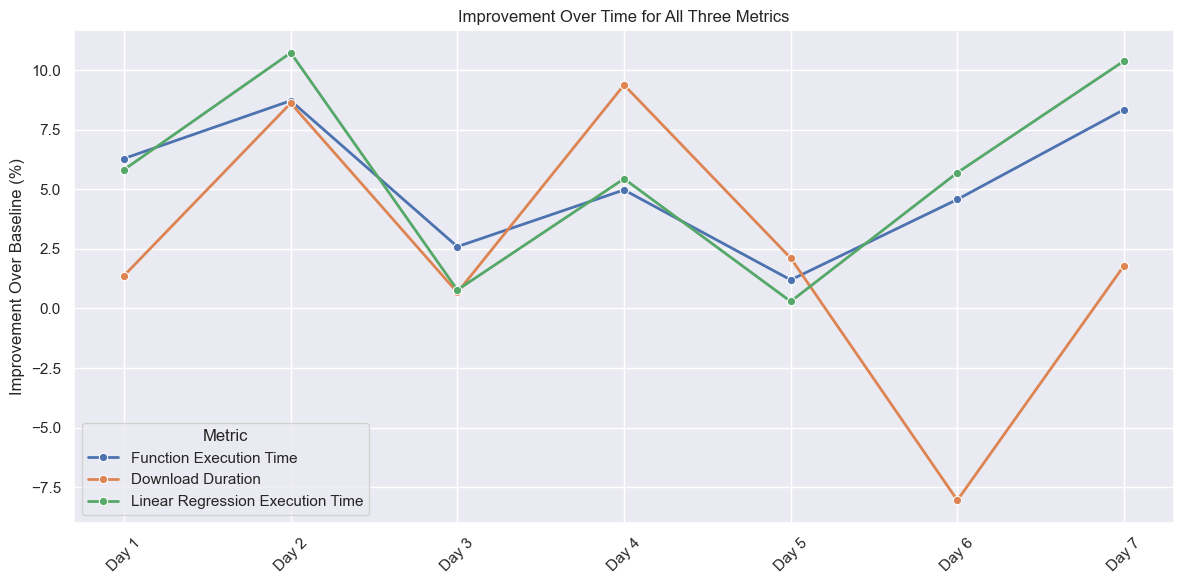

In [16]:
# 1ST FUNC EXEC TIME, DOWNLOAD DURATION, LR EXEC TIME
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df_filtered, 
    x="day_label", 
    y="% Improvement", 
    hue="Metric", 
    lw=2, 
    palette=palette[:3],
    marker="o"
)

# Add labels and title
plt.xlabel(None)
plt.ylabel(y_axis_label)
plt.title("Improvement Over Time for All Three Metrics")

# Format x-axis ticks
plt.xticks(rotation=45)

# Start y-axis at 0
# plt.ylim(bottom=0)

# Add a legend
plt.legend(title="Metric")

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "improvement_all_metrics" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

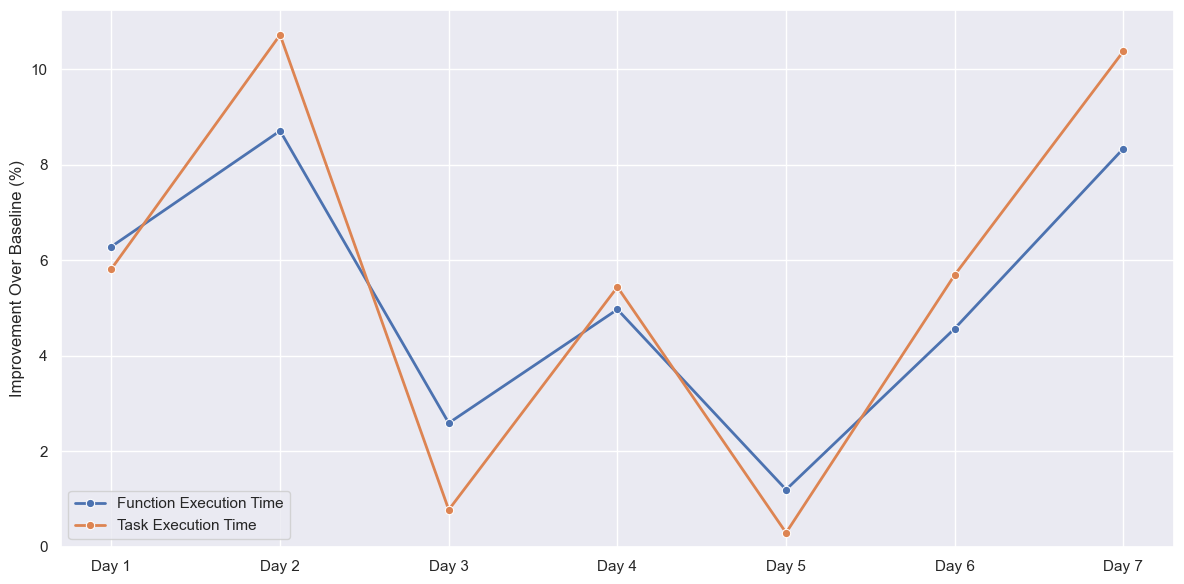

In [17]:
# 2ND FUNC EXEC TIME vs LR EXECUTION TIME

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df_filtered_task_2, 
    x="day_label", 
    y="% Improvement", 
    hue="Metric", 
    lw=2, 
    palette=palette[:2],  # Use only the first two colors for consistency
    marker="o"
)

# Add labels and title
plt.xlabel(None)
plt.ylabel(y_axis_label)
# plt.title("Comparison: Function Execution Time vs. Linear Regression Execution Time")

# Start y-axis at 0
plt.ylim(bottom=0)

# Add a legend
plt.legend(title=None)

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "improvement_function_exec_vs_linear_regression" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

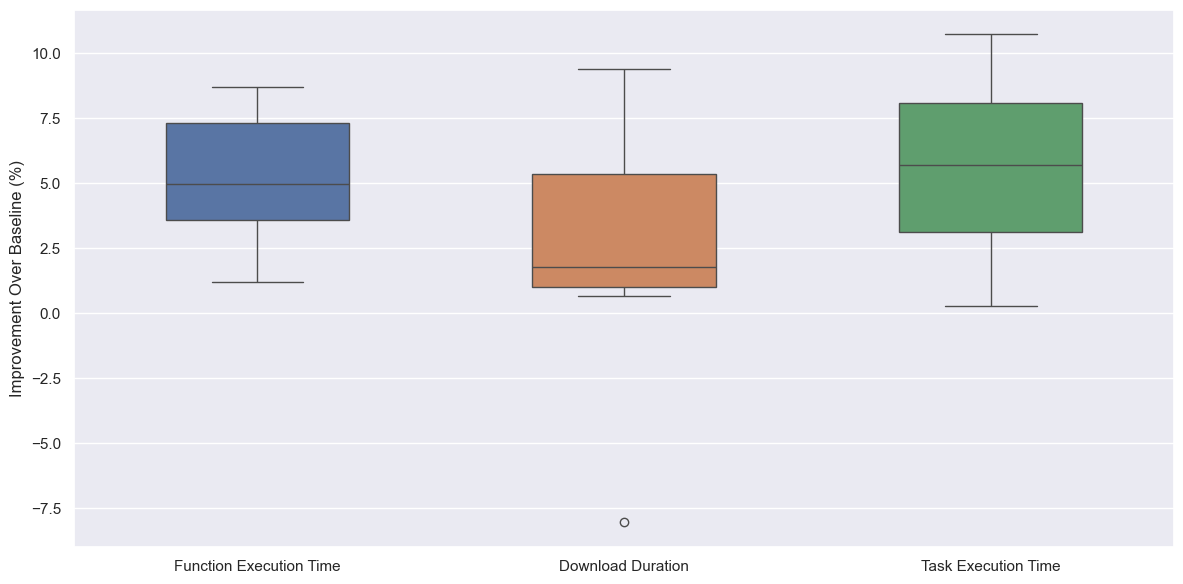

In [18]:
# 3RD BOXPLOT: FUNC EXEC TIME, DOWNLOAD DURATION, LR EXEC TIME

# --- Boxplot for Each Metric ---
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df_filtered_task, 
    x="Metric", 
    y="% Improvement", 
    hue="Metric",  # Assign Metric to hue
    palette=palette[:3],  # Use the chosen palette
    width=0.5
)

# Add labels and title
# plt.xlabel("Metric")
plt.xlabel(None)
# plt.xticks(rotation=25)
plt.ylabel(y_axis_label)
# plt.title("Distribution of % Improvement Over Baseline for Each Metric")

# plt.ylim(bottom=0)
# plt.ylim(df_filtered["% Improvement"].min() - 1, df_filtered["% Improvement"].max() + 1)

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "boxplot_improvement_by_metric" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

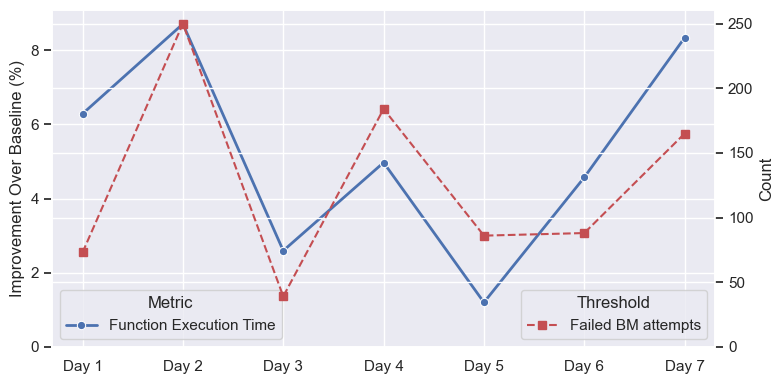

In [19]:
# 4TH FUNCTION EXEC TIME vs FAILED BM COUNT -> COUNT
plt.figure(figsize=(8, 4))

# First y-axis (Percentage Improvement)
ax1 = plt.gca()  # Get current axis
sns.lineplot(
    data=df_function_execution_time, 
    x="day_label", 
    y="% Improvement", 
    hue="Metric", 
    lw=2, 
    palette=palette[:1],  # Use only the first two colors for consistency
    marker="o",
    ax=ax1
)

# Set labels for the first y-axis
ax1.set_xlabel(None)
ax1.set_ylabel(y_axis_label)
ax1.tick_params(axis='y')

# Start y-axis at 0
ax1.set_ylim(bottom=0)

# Add a second y-axis (Milliseconds)
ax2 = ax1.twinx()
ax2.plot(
    df_function_execution_time["day_label"].unique(), 
    failed_benchmark_count_array, 
    color=palette[3], 
    linestyle="--", 
    marker="s", 
    label="Failed BM attempts"
)

# Set labels for the second y-axis
ax2.set_ylabel("Count")
ax2.tick_params(axis='y')

# Add legends
ax1.legend(title="Metric", loc="lower left")
ax2.legend(title="Threshold", loc="lower right")

ax2.set_ylim(bottom=0)

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "function_execution-vs-failed_bm_count" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

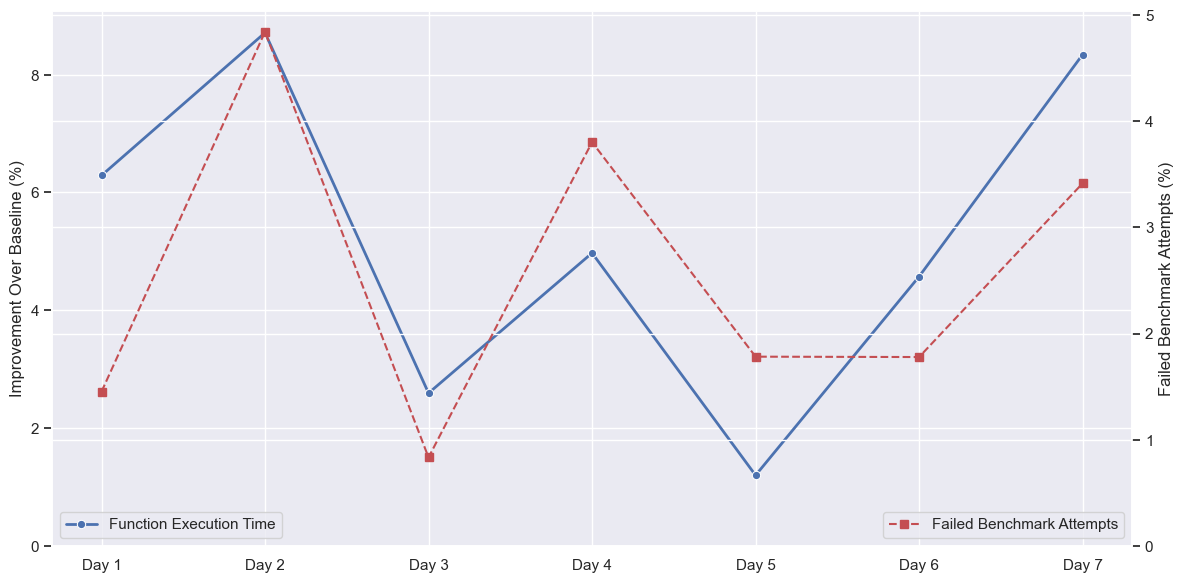

In [20]:
# 5TH FUNCTION EXEC TIME vs FAILED BM COUNT -> PERCENTAGE
plt.figure(figsize=(12, 6))

# First y-axis (Percentage Improvement)
ax1 = plt.gca()  # Get current axis
sns.lineplot(
    data=df_function_execution_time, 
    x="day_label", 
    y="% Improvement", 
    hue="Metric", 
    lw=2, 
    palette=palette[:1],  # Use only the first two colors for consistency
    marker="o",
    ax=ax1
)

# Set labels for the first y-axis
ax1.set_xlabel(None)
ax1.set_ylabel(y_axis_label)
ax1.tick_params(axis='y')

# Start y-axis at 0
ax1.set_ylim(bottom=0)

# Add a second y-axis (Milliseconds)
ax2 = ax1.twinx()
ax2.plot(
    df_function_execution_time["day_label"].unique(), 
    failed_benchmark_count_percentage_array, 
    color=palette[3], 
    linestyle="--", 
    marker="s", 
    label="Failed Benchmark Attempts"
)

# Set labels for the second y-axis
ax2.set_ylabel(y_axis_label_bm_failed_attempts)
ax2.tick_params(axis='y')

# Add legends
ax1.legend(title=None, loc="lower left")
ax2.legend(title=None, loc="lower right")

ax2.set_ylim(bottom=0)

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "function_execution-vs-failed_bm_percentage" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

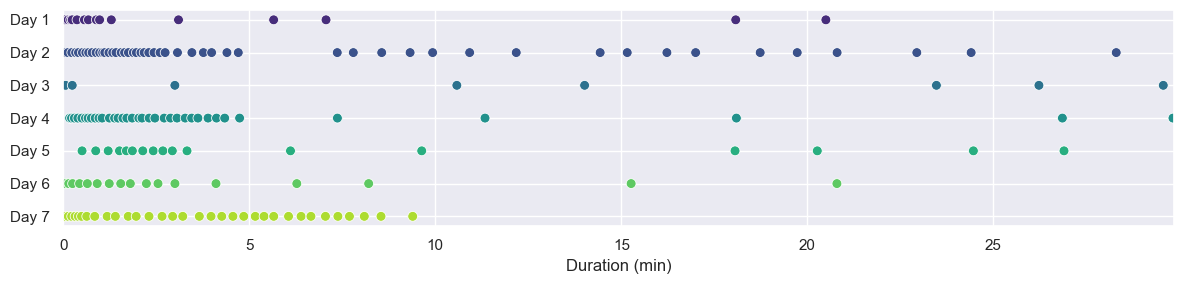

In [21]:
# 6TH ANALYSE FAILED BM ATTEMPTS
aggregated_timestamps = []

for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-optimizedFunction-logs.csv'
    df = pd.read_csv(file_path)

    # Convert timestamp to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Determine the experiment start time (earliest timestamp)
    experiment_start = df['timestamp'].min()

    # Filter failed benchmarks and store their relative minutes
    failed_timestamps = []

    # Extract the relative minute for each fail
    for _, row in df.iterrows():
        if isinstance(row['benchmark_duration'], str):
            if row['benchmark_duration'].startswith("BM:"):
                timestamp = (row['timestamp'] - experiment_start).total_seconds() / 60
                failed_timestamps.append(timestamp)

    # Store all failed timestamps with their corresponding date
    if failed_timestamps:
        for ts in failed_timestamps:
            aggregated_timestamps.append((date, ts))

# Create a DataFrame for seaborn visualization
df_aggregated = pd.DataFrame(aggregated_timestamps, columns=['Date', 'Failed Timestamp'])

# Sample the data by selecting every 5th point (you can adjust this number)
df_sampled = df_aggregated.iloc[::5, :].copy()  # Adjust the number as needed

df_sampled['day_label'] = df_sampled['Date'].map(date_mapping)

# Plot with Seaborn
plt.figure(figsize=(12, 3))
sns.scatterplot(
    data=df_sampled, 
    x='Failed Timestamp', 
    y='day_label', 
    hue='Date', 
    palette=color_palette_style_2, 
    s=50,
    legend=False
)

# Customize plot
plt.xlim(left=0, right=max_duration)
# plt.title("Sampled Failed Benchmark Attempts by Date")
plt.xlabel("Duration (min)")
plt.ylabel(None)
plt.grid(True)
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "scatterplot-failed-bm-attempts" + file_ending)
plt.savefig(plot_filename)

plt.show()

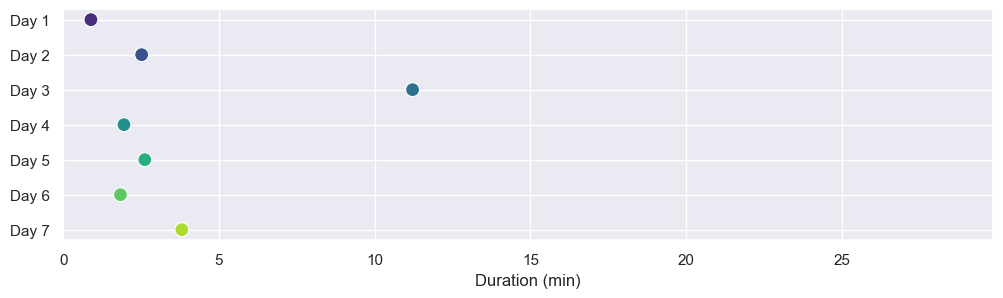

In [22]:
# 6.1 ANALYSE FAILED BM ATTEMPT MEDIANS ONE PLOT
aggregated_timestamps = []

for date in dates:
    file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-optimizedFunction-logs.csv'
    df = pd.read_csv(file_path)

    # Convert timestamp to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Determine the experiment start time (earliest timestamp)
    experiment_start = df['timestamp'].min()

    # Filter failed benchmarks and store their relative minutes
    failed_timestamps = []

    # Extract the relative minute for each fail
    for _, row in df.iterrows():
        if isinstance(row['benchmark_duration'], str):
            if row['benchmark_duration'].startswith("BM:"):
                timestamp = (row['timestamp'] - experiment_start).total_seconds() / 60
                failed_timestamps.append(timestamp)

    # Compute the median of the failed timestamps (you can also use .mean() for average)
    if failed_timestamps:
        median_timestamp = pd.Series(failed_timestamps).median()
        aggregated_timestamps.append((date, median_timestamp))

# Create a DataFrame for seaborn visualization
df_aggregated = pd.DataFrame(aggregated_timestamps, columns=['Date', 'Median Timestamp'])

df_aggregated['day_label'] = df_aggregated['Date'].map(date_mapping)

# Plot with Seaborn
plt.figure(figsize=(12, 3))
sns.scatterplot(
    data=df_aggregated, 
    x='Median Timestamp', 
    y='day_label', 
    hue='Date', 
    palette=color_palette_style_2, 
    s=100,
    legend=False
)

# Customize plot
plt.xlim(left=0, right=max_duration)
# plt.title("Median of Failed Benchmark Attempts by Date")
plt.xlabel("Duration (min)")
plt.ylabel(None)
plt.grid(True)
plt.show()

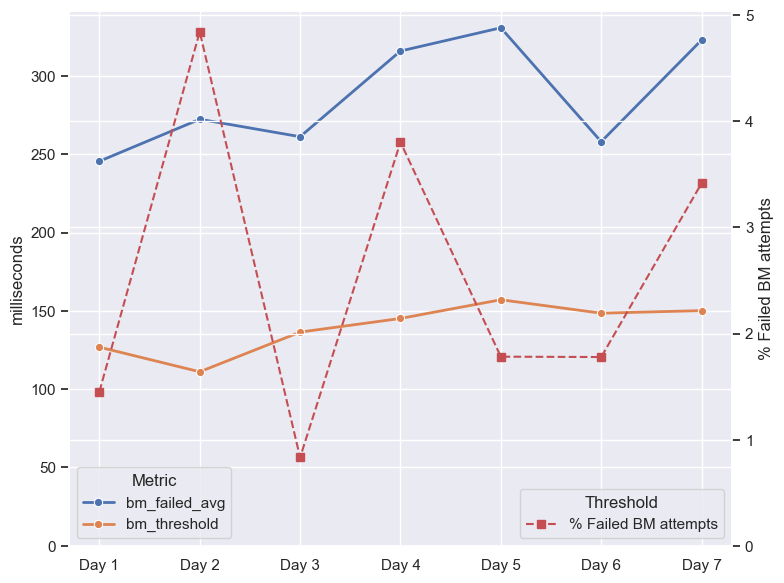

In [23]:
# 7TH THRESHOLD, FAILED AVG, % FAILED BM 
plt.figure(figsize=(8, 6))

# First y-axis (bm_threshold_array)
ax1 = plt.gca()  # Get current axis

sns.lineplot(
    data=df_bm_and_failedavg, 
    x="day_label", 
    y="Value", 
    hue="Metric", 
    lw=2, 
    marker="o",
    ax=ax1
)

# Set labels for the first y-axis
ax1.set_xlabel(None)
ax1.set_ylabel("milliseconds")
ax1.tick_params(axis='y')

# Start y-axis at 0
ax1.set_ylim(bottom=0)

# Second y-axis (Failed Benchmark Count)
ax2 = ax1.twinx()
ax2.plot(
    df_filtered2["day_label"].unique(), 
    failed_benchmark_count_percentage_array, 
    color=palette[3], 
    linestyle="--", 
    marker="s", 
    label="% Failed BM attempts"
)

# Set labels for the second y-axis
ax2.set_ylabel("% Failed BM attempts")
ax2.tick_params(axis='y')

# Add legends
ax1.legend(title="Metric", loc="lower left")
ax2.legend(title="Threshold", loc="lower right")

ax2.set_ylim(bottom=0)

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "improvement_function_exec_vs_linear_regression_2" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

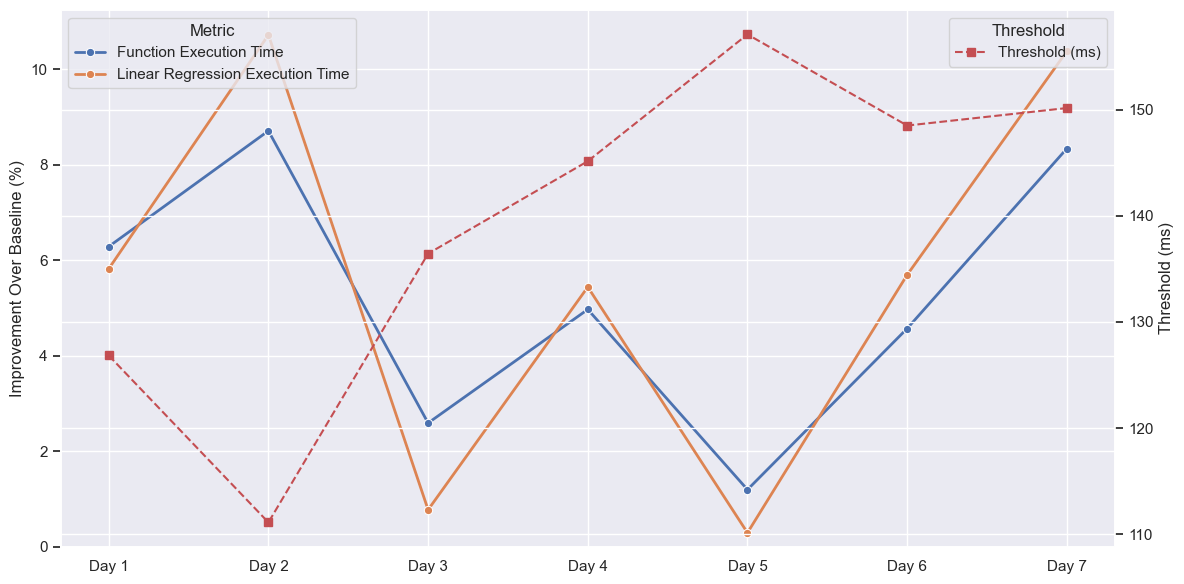

In [24]:
# 8TH FUNC EXEC TIME vs LR EXEC TIME vs THRESHOLD
plt.figure(figsize=(12, 6))

# First y-axis (Percentage Improvement)
ax1 = plt.gca()  # Get current axis
sns.lineplot(
    data=df_filtered2, 
    x="day_label", 
    y="% Improvement", 
    hue="Metric", 
    lw=2, 
    palette=palette[:2],  # Use only the first two colors for consistency
    marker="o",
    ax=ax1
)

# Set labels for the first y-axis
ax1.set_xlabel(None)
ax1.set_ylabel(y_axis_label)
ax1.tick_params(axis='y')

# Start y-axis at 0
ax1.set_ylim(bottom=0)

# Add a second y-axis (Milliseconds)
ax2 = ax1.twinx()
ax2.plot(
    df_filtered2["day_label"].unique(), 
    bm_threshold_array, 
    color=palette[3], 
    linestyle="--", 
    marker="s", 
    label="Threshold (ms)"
)

# Set labels for the second y-axis
ax2.set_ylabel("Threshold (ms)")
ax2.tick_params(axis='y')

# Add legends
ax1.legend(title="Metric", loc="upper left")
ax2.legend(title="Threshold", loc="upper right")

# ax2.set_ylim(bottom=0)

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "function_exec-vs-lr_exec-vs-threshold" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

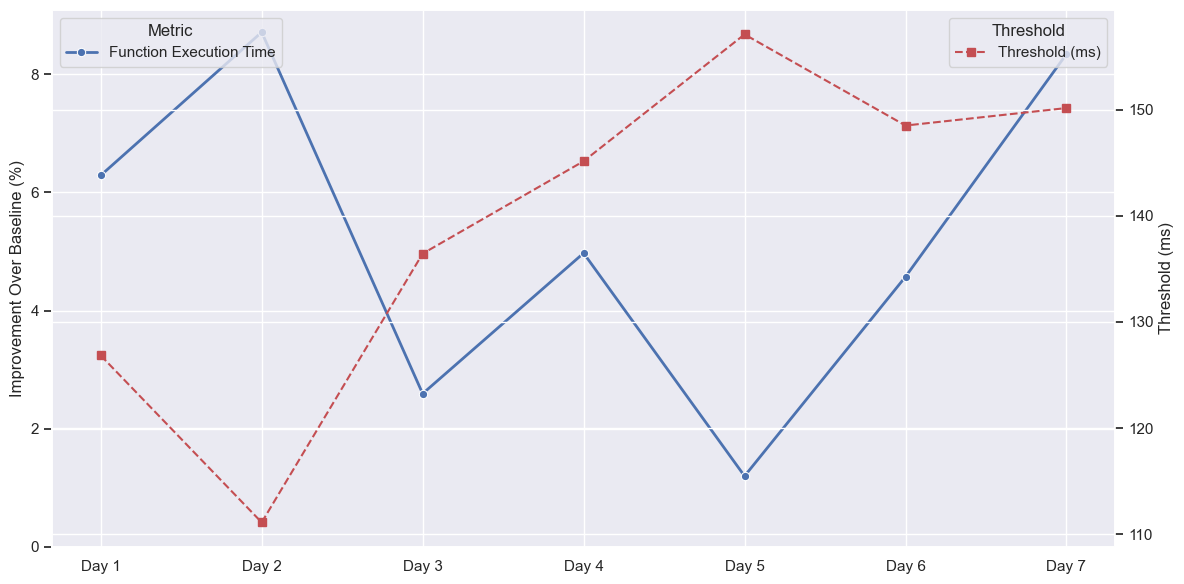

In [25]:
# 9TH FUNC EXEC TIME vs THRESHOLD
plt.figure(figsize=(12, 6))

# First y-axis (Percentage Improvement)
ax1 = plt.gca()  # Get current axis
sns.lineplot(
    data=df_function_execution_time, 
    x="day_label", 
    y="% Improvement", 
    hue="Metric", 
    lw=2, 
    palette=palette[:1],  # Use only the first two colors for consistency
    marker="o",
    ax=ax1
)

# Set labels for the first y-axis
ax1.set_xlabel(None)
ax1.set_ylabel(y_axis_label)
ax1.tick_params(axis='y')

# Start y-axis at 0
ax1.set_ylim(bottom=0)

# Add a second y-axis (Milliseconds)
ax2 = ax1.twinx()
ax2.plot(
    df_filtered2["day_label"].unique(), 
    bm_threshold_array, 
    color=palette[3], 
    linestyle="--", 
    marker="s", 
    label="Threshold (ms)"
)

# Set labels for the second y-axis
ax2.set_ylabel("Threshold (ms)")
ax2.tick_params(axis='y')

# Add legends
ax1.legend(title="Metric", loc="upper left")
ax2.legend(title="Threshold", loc="upper right")

# ax2.set_ylim(bottom=0)

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "function_exec-vs-threshold" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

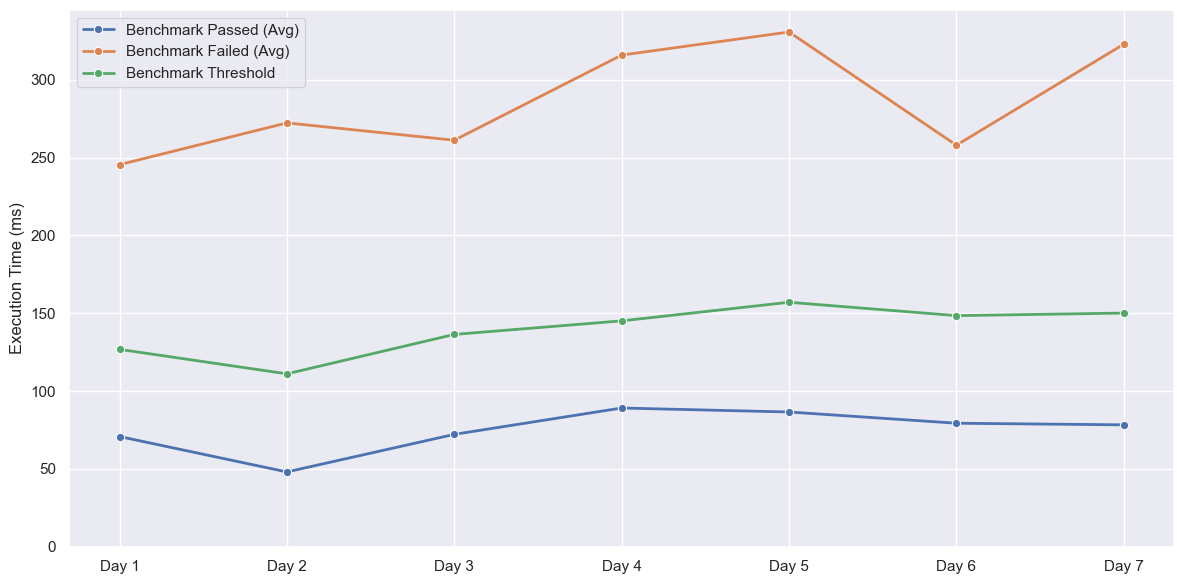

In [26]:
# Passed Avg, Failed Avg, Threshold
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df_melted_avg, 
    x="day_label", 
    y="Value", 
    hue="Metric", 
    lw=2, 
    palette=palette[:3],
    marker="o"
)

# Add labels and title
plt.xlabel(None)
plt.ylabel("Execution Time (ms)")
# plt.title("Benchmark Metrics Over Time (Passed Avg, Failed Avg, Threshold)")

# Start y-axis at 0
plt.ylim(bottom=0)

legend_labels = {
    "bm_passed_avg": "Benchmark Passed (Avg)",
    "bm_failed_avg": "Benchmark Failed (Avg)",
    "bm_threshold": "Benchmark Threshold"
}

# Get the legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Replace the labels with the custom ones
new_labels = [legend_labels[label] for label in labels]

# Update the legend with the new labels
plt.legend(handles, new_labels, title=None)

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "threshold-passed-failed-avg" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

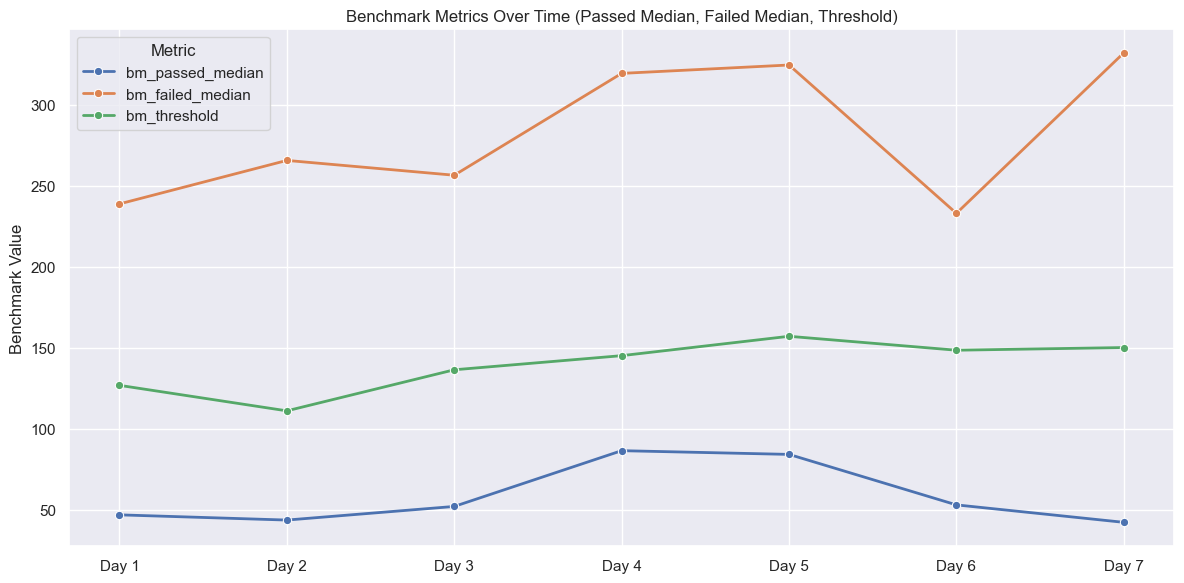

In [27]:
# Passed Median, Failed Median, Threshold
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df_melted_median, 
    x="day_label", 
    y="Value", 
    hue="Metric", 
    lw=2, 
    palette=palette[:3],
    marker="o"
)

# Add labels and title
plt.xlabel(None)
plt.ylabel("Benchmark Value")
plt.title("Benchmark Metrics Over Time (Passed Median, Failed Median, Threshold)")

# Add a legend
plt.legend(title="Metric")

# Adjust layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "threshold-passed-failed-median" + file_ending)
plt.savefig(plot_filename)

# Show plot
plt.show()

##### Single day

In [28]:
# SETUP DATA FOR PLOT

df_optimized = pd.read_csv(f"./logs_analysis/2025-02-04/execution_{execution_count}/2025-02-04-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_analysis/2025-02-04/execution_{execution_count}/2025-02-04-baselineFunction-logs.csv")

# Convert 'timestamp' col to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])
# Create col duration in minutes for x-axis
df_optimized['duration_minutes'] = (df_optimized['timestamp'] - df_optimized['timestamp'].min()).dt.total_seconds() / 60
df_baseline['duration_minutes'] = (df_baseline['timestamp'] - df_baseline['timestamp'].min()).dt.total_seconds() / 60
# Create col for smoothed execution time
df_optimized['smoothed_execution_time'] = df_optimized['execution_time'].rolling(window=75).mean()
df_baseline['smoothed_execution_time'] = df_baseline['execution_time'].rolling(window=75).mean()
# Create col for smoothed lr-duration
df_optimized = df_optimized[df_optimized['lr_duration'] != 0] # filter out zeros
df_optimized['smoothed_lr_duration'] = df_optimized['lr_duration'].rolling(window=75).mean()
df_baseline['smoothed_lr_duration'] = df_baseline['lr_duration'].rolling(window=75).mean()

df_optimized = df_optimized[df_optimized['lr_duration'] != 0]

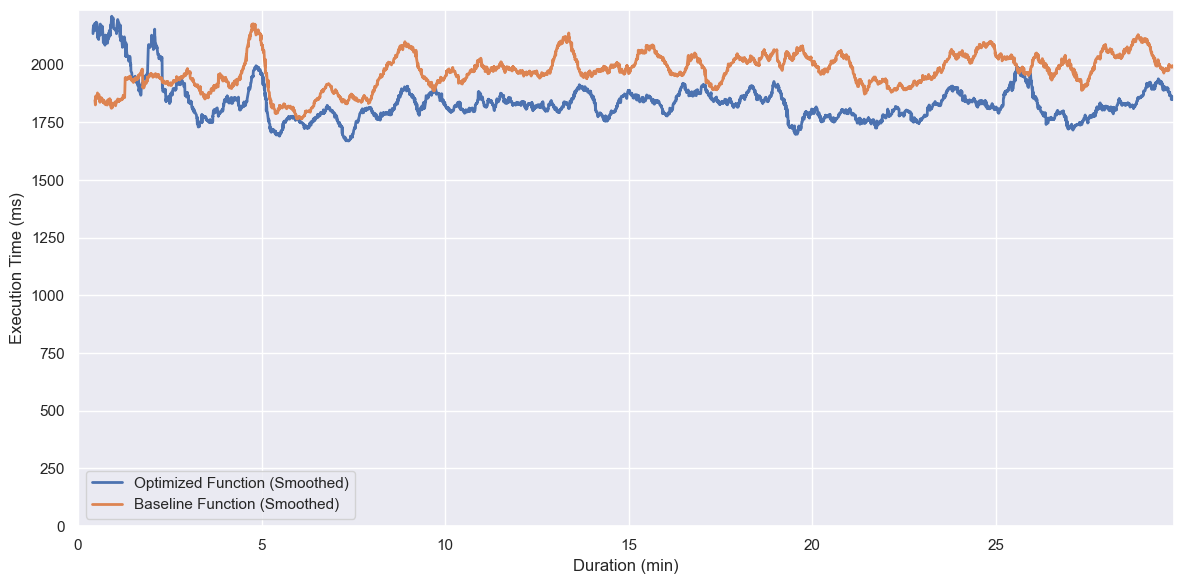

In [29]:
# EXECUTION TIME ROLLING AVG

sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='smoothed_execution_time', color=palette[0], label='Optimized Function (Smoothed)', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='duration_minutes', y='smoothed_execution_time', color=palette[1], label='Baseline Function (Smoothed)', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
# plt.title('Comparison of Optimized vs Baseline Function Execution Times (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0, right=max_duration)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(folder_to_save, "2025-02-04-execution-times-rolling-avg" + file_ending)
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 

##### ARCHIVE

In [30]:
# 6TH ANALYSE FAILED BM ATTEMPTS

# for date in dates:
#     file_path = f'./logs_analysis/{date}/execution_{execution_count}/{date}-optimizedFunction-logs.csv'
#     df = pd.read_csv(file_path)

#     # Convert timestamp to datetime format
#     df['timestamp'] = pd.to_datetime(df['timestamp'])

#     # Determine the experiment start time (earliest timestamp)
#     experiment_start = df['timestamp'].min()

#     # Filter passed and failed benchmarks and store their relative minutes
#     passed_timestamps = []
#     failed_timestamps = []

#     # Extract the relative minute for each pass
#     for _, row in df.iterrows():
#         if isinstance(row['benchmark_duration'], str):
#             if row['benchmark_duration'].startswith("BM PASSED:"):
#                 timestamp = (row['timestamp'] - experiment_start).total_seconds() / 60
#                 passed_timestamps.append(timestamp)
#             elif row['benchmark_duration'].startswith("BM:"):
#                 timestamp = (row['timestamp'] - experiment_start).total_seconds() / 60
#                 failed_timestamps.append(timestamp)

#     # Create a DataFrame for seaborn visualization
#     df_plot = pd.DataFrame({
#         'Timestamp': failed_timestamps,
#         'Benchmark Type': ['Failed'] * len(failed_timestamps)
#     })

#     # Plot with Seaborn
#     plt.figure(figsize=(12, 2))
#     sns.scatterplot(
#         data=df_plot, 
#         x='Timestamp', 
#         y='Benchmark Type', 
#         hue='Benchmark Type', 
#         palette=palette[:1], 
#         s=50
#     )

#     plt.xlim(0, 30)
#     # Customize plot
#     plt.title(f"Failed Benchmark Attempts on {date}")
#     plt.xlabel("Relative Time (Minutes)")
#     plt.ylabel("Benchmark Type")
#     plt.grid(True)
#     plt.show()